In [1]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas_datareader.data as web
%matplotlib inline

## データの準備
pandas_datareaderを利用してyahooファイナンスから価格を取得する

In [2]:
start = datetime.date.today() - datetime.timedelta(days=20*365)
ohlcv = web.DataReader('MSFT', 'yahoo', start).dropna(axis=0)
ohlcv.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-30,204.460007,199.570007,201.000000,203.899994,25079600.0,203.899994
2020-07-31,205.100006,199.009995,204.399994,205.009995,51248000.0,205.009995
2020-08-03,217.639999,210.440002,211.520004,216.539993,78983000.0,216.539993
2020-08-04,214.770004,210.309998,214.169998,213.289993,49245300.0,213.289993
2020-08-05,215.000000,212.074997,214.899994,212.695007,14942547.0,212.695007


## 騰落率に変換する(定常化)
調整後終値(Adj Close)に合わせて、高値安値始値も調整します。  
調整後終値については[こちら](https://support.yahoo-net.jp/PccFinance/s/article/H000006678)を参照して下さい。

In [3]:
data = pd.DataFrame(index=ohlcv.index, columns=[])
data['Adj_High'] = ohlcv['High'] * ohlcv['Adj Close'] / ohlcv['Close']
data['Adj_Low'] = ohlcv['Low'] * ohlcv['Adj Close'] / ohlcv['Close']
data['Adj_Open'] = ohlcv['Open'] * ohlcv['Adj Close'] / ohlcv['Close']
data['Adj_Close'] = ohlcv['Adj Close']
data = data.pct_change().dropna(axis=0)
data.tail()

,Adj_High,Adj_Low,Adj_Open,Adj_Close
Date,,,,
2020-07-30,-0.000928,-0.012079,-0.007407,-0.000784
2020-07-31,0.003130,-0.002806,0.016915,0.005444
2020-08-03,0.061141,0.057434,0.034834,0.056241
2020-08-04,-0.013187,-0.000618,0.012528,-0.015009
2020-08-05,0.001071,0.008392,0.003408,-0.002790


## 計算スピード向上のためnumpy化

In [4]:
data = data.values
print(data.shape)

(5027, 4)


In [5]:
print(data[:6, :])

[[-1.85651925e-02 -1.74194836e-03 -1.86280728e-02 -2.58154386e-03]
 [ 9.45883508e-03 -3.48987072e-03 -1.72509392e-03 -3.45072038e-03]
 [-5.11107972e-03  1.75096391e-03 -4.32186863e-03 -7.79255403e-03]
 [-1.02742520e-02 -1.31121667e-02 -1.73639288e-03 -8.72628328e-03]
 [-3.46010368e-03  1.04288388e-07 -1.04346794e-02  7.92264033e-03]
 [-7.81260347e-03 -7.97175979e-03 -1.04288377e-07 -7.86036548e-03]]


## future_days日後の終値変動率を予測
yにリターンとして終値を格納し、Xに特徴量として高値、安値、始値、終値のデータを格納する。

In [6]:
future_days = 1
y = data[future_days:, 3]
print(y.shape)
X = data[:len(data) - future_days, :]
print(X.shape)

(5026,)
(5026, 4)


## 入力層の準備
time_steps日分のデータで予測する

In [7]:
time_steps = 100
X_new = np.zeros((X.shape[0] - time_steps + 1, time_steps, X.shape[1]))
y_new = np.zeros((y.shape[0] - time_steps + 1, 1))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :] = X[ix + jx, :]
    y_new[ix] = y[ix + time_steps -1]
print(X_new.shape, y_new.shape)

(4927, 100, 4) (4927, 1)


## ホールドアウト法で学習用とテスト用のデータを分離する

In [8]:
split = int(0.8 * data.shape[0])
X_train = X_new[:split]
X_test = X_new[split:]

y_train = y_new[:split]
y_test = y_new[split:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4021, 100, 4) (4021, 1)
(906, 100, 4) (906, 1)


## モデル作成

In [9]:
model = Sequential()

model.add(Conv1D(64, 3, input_shape=(X_train.shape[1], X_train.shape[2]), padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=1))
model.add(Activation('tanh'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 64)           832       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50, 100)           66000     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0

## 訓練過程の設定
最適化アルゴリズムにAdamを採用する。

In [10]:
model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])

## 学習を開始する
EarlyStoppingを利用し、過学習の状態となったら自動的に終了する。

In [11]:
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), callbacks=[es_cb], verbose=2)

Epoch 1/100
16/16 - 1s - loss: 4.2228e-04 - acc: 0.0124 - mae: 0.0147 - val_loss: 3.7470e-04 - val_acc: 0.0088 - val_mae: 0.0133
Epoch 2/100
16/16 - 0s - loss: 3.4682e-04 - acc: 0.0124 - mae: 0.0128 - val_loss: 3.3439e-04 - val_acc: 0.0088 - val_mae: 0.0117
Epoch 3/100
16/16 - 0s - loss: 3.3470e-04 - acc: 0.0124 - mae: 0.0125 - val_loss: 3.3121e-04 - val_acc: 0.0088 - val_mae: 0.0116
Epoch 4/100
16/16 - 0s - loss: 3.3273e-04 - acc: 0.0124 - mae: 0.0124 - val_loss: 3.2798e-04 - val_acc: 0.0088 - val_mae: 0.0115
Epoch 5/100
16/16 - 0s - loss: 3.3366e-04 - acc: 0.0124 - mae: 0.0124 - val_loss: 3.2756e-04 - val_acc: 0.0088 - val_mae: 0.0115
Epoch 6/100
16/16 - 0s - loss: 3.3143e-04 - acc: 0.0124 - mae: 0.0125 - val_loss: 3.2960e-04 - val_acc: 0.0088 - val_mae: 0.0116
Epoch 7/100
16/16 - 0s - loss: 3.2923e-04 - acc: 0.0124 - mae: 0.0124 - val_loss: 3.3105e-04 - val_acc: 0.0088 - val_mae: 0.0116
Epoch 8/100
16/16 - 0s - loss: 3.3099e-04 - acc: 0.0124 - mae: 0.0125 - val_loss: 3.2995e-04 - va

## 学習の進み具合を可視化
学習した結果lossとテストデータのval_lossが収束している事がわかる

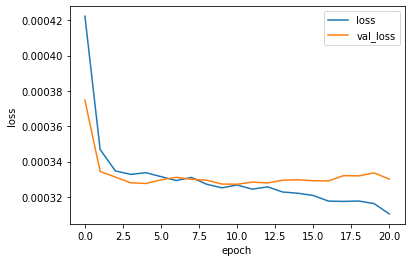

In [12]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='loss')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.show()

## テストデータで学習結果を評価する

In [13]:
score = model.evaluate(X_test, y_test, batch_size=256)
print('loss:', score[0])
print('acc:', score[1])
print('mae:', score[2])

4/4 [==============================] - 0s 4ms/step - loss: 3.3003e-04 - acc: 0.0088 - mae: 0.0116
loss: 0.000330033537466079
acc: 0.008830022066831589
mae: 0.011581997387111187


## テストデータの予測結果(y_pred)を作成する

In [14]:
y_pred = model.predict(X_test)

## 予測結果の確認
正答率、情報係数(IC)、リターンを計算します。  
ICは0.05以上で優秀な指標、0.1以上で非常に優秀な指標となります。  
リターンは予測が+方向なら買い、-方向なら売りを行った結果です。

P: 0.5381
IC: 0.0762
return: 256.44 %


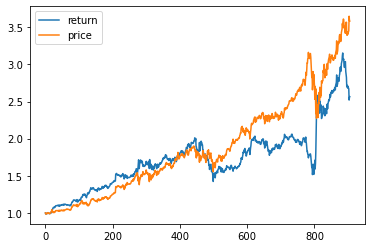

In [15]:
profit = []
profit.append(float(1 * (1 + y_test[0])))
i = 1
while(i < len(y_test)):
    if y_pred[i] < 0:
        profit.append(float(profit[-1] * (1 - y_test[i])))
    else:
        profit.append(float(profit[-1] * (1 + y_test[i])))
    i = i + 1

price = []
price.append(float(1 * (1 + y_test[0])))
i = 1
while(i < len(y_test)):
    price.append(float(price[-1] * (1 + y_test[i])))
    i = i + 1

data_score = 0
for i in range(y_test.shape[0] - 1):
    if y_test[i] > 0 and y_pred[i] > 0:
        data_score += 1
    elif y_test[i] < 0 and y_pred[i] < 0:
        data_score += 1
score = data_score / (y_test.shape[0] - 1)
ic = 2 * score - 1

print('P:', round(score, 4))
print('IC:', round(ic, 4))
print('return:', round(profit[-1]*100, 2), '%')
plt.plot(profit, label='return')
plt.plot(price, label='price')
plt.legend() 
plt.show()

## リターン(終値)と学習モデル(指標)の相関係数

IC: 0.06147


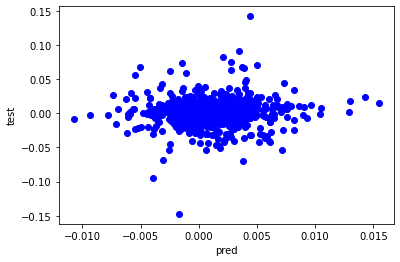

In [16]:
print(f'IC: {round(np.corrcoef(np.ravel(y_pred), np.ravel(y_test))[0,1], 5)}')
plt.plot (y_pred, y_test, 'bo')
plt.xlabel('pred')
plt.ylabel('test')
plt.show()

## おわりに
この簡単なモデルでは騰落の正答率が53.8%、IC 0.076となりました。  
ICを考えれば0.05以上で優秀な指標なので、儲かるモデルが作れたかのように思えます。  
しかし、最初に購入して放置した場合のリターンが350%、モデル通りにトレードして256%と、買って何もしない方が強い状態です。  
がっかりさせてしまったかもしれませんが、機械学習をトレードに利用する事は簡単ではありません。  
ただ、機械学習を利用して収益を上げている方もいらっしゃいますので、このノートブックが貴方の第一歩になれば幸いです。  